# MOXSI Channel Refactor

A few notes on refactoring the `Channel` object in `mocksipipeline` to deal with the new grating efficiency files.

In [ ]:
import astropy.units as u
import astropy.constants as const
import astropy.table
from astropy.visualization import quantity_support
import numpy as np
import matplotlib.pyplot as plt

from mocksipipeline.detector.response import Channel, SpectrogramChannel, ThinFilmFilter

In [2]:
ch = Channel('filtergram_1')

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


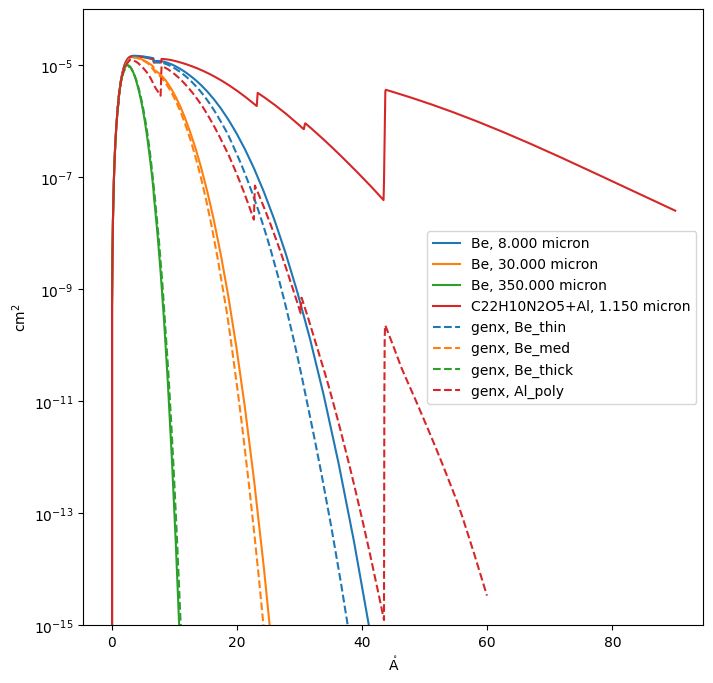

In [3]:
plt.figure(figsize=(8,8))
for i in range(4):
    ch = Channel(f'filtergram_{i+1}')
    with quantity_support():
        plt.plot(ch.wavelength, ch.effective_area, label=ch.filter_label, color=f'C{i}', ls='-')
for i,name in enumerate(['Be_thin', 'Be_med', 'Be_thick', 'Al_poly']):
    genx_data = ch._read_genx_instrument_data(name)
    plt.plot(genx_data['wave'], genx_data['effarea'], label=f'genx, {name}', color=f'C{i}', ls='--')
plt.yscale('log')
plt.ylim(1e-15, 1e-4)
plt.legend()

In [4]:
au_layer = ThinFilmFilter(elements='Au', thickness=20*u.nm, xrt_table='Chantler')
cr_layer = ThinFilmFilter(elements='Cr', thickness=5*u.nm, xrt_table='Chantler')

(1e-06, 1)

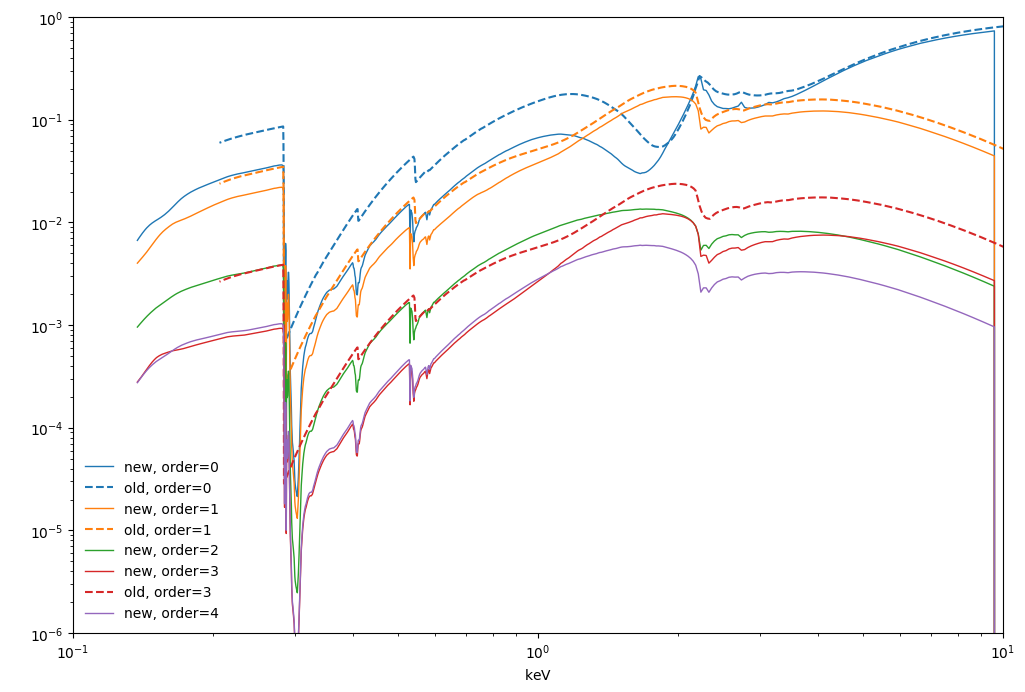

In [7]:
plt.figure(figsize=(12,8))
with quantity_support():
    for i in np.arange(0,5):
        ch = SpectrogramChannel(i)
        l, = plt.plot(ch.energy.to('keV'), ch.grating_efficiency, label=f'new, order={ch.spectral_order}', lw=3 if i<0 else 1)
        if (i == 0 or i%2 != 0) and i<6:
            name = f"MOXSI_S{abs(i)}"
            genx_data = ch._read_genx_instrument_data(name)
            genx_wave = genx_data['wave']*u.angstrom
            genx_energy = const.h * const.c / genx_wave
            au_cr_layer = au_layer.transmissivity(genx_energy) * cr_layer.transmissivity(genx_energy)
            old_ge = genx_data['grating'] * au_cr_layer
            plt.plot(genx_energy, old_ge, label=f'old, order={ch.spectral_order}', color=l.get_color(), ls='--')
plt.legend(frameon=False)
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.1, 10)
plt.ylim(1e-6, 1)

(1e-06, 1)

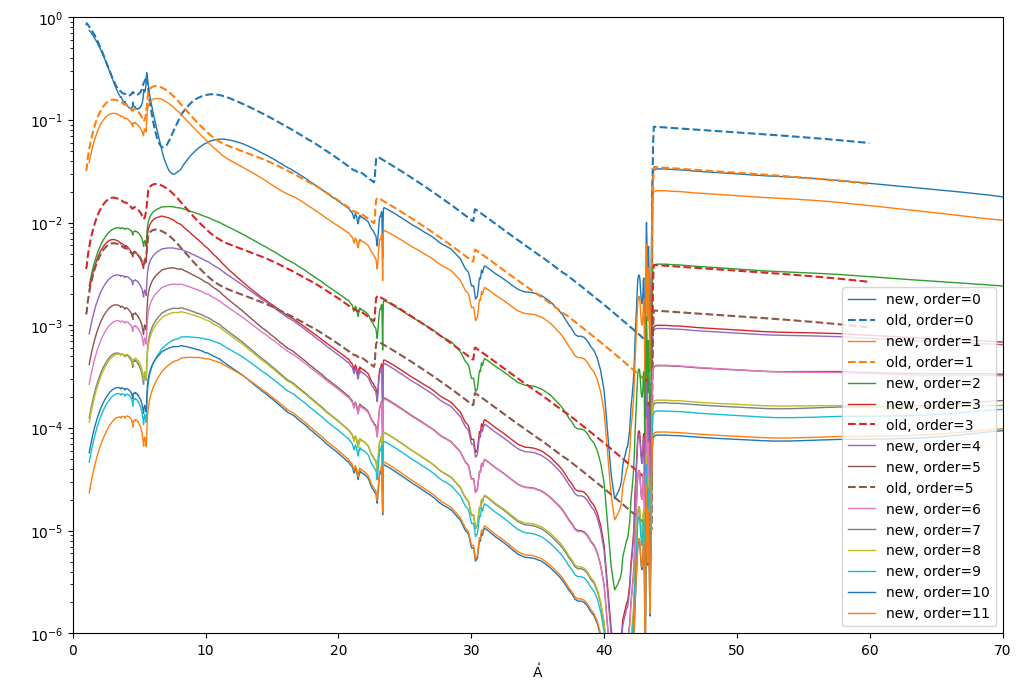

In [8]:
plt.figure(figsize=(12,8))
for i in np.arange(0,12):
    ch = SpectrogramChannel(0)
    tab = ch._read_grating_file(ch.grating_file, 3)
    with quantity_support():
        l, = plt.plot(tab['wavelength'], tab[f'grating_efficiency_{i}'], label=f'new, order={i}', lw=3 if i<0 else 1)
    if (i == 0 or i%2 != 0) and i<6:
        name = f"MOXSI_S{abs(i)}"
        genx_data = ch._read_genx_instrument_data(name)
        genx_wave = genx_data['wave']*u.angstrom
        genx_energy = const.h * const.c / genx_wave
        au_cr_layer = au_layer.transmissivity(genx_energy) * cr_layer.transmissivity(genx_energy)
        old_ge = genx_data['grating'] * au_cr_layer
        with quantity_support():
            plt.plot(genx_wave, old_ge, label=f'old, order={i}', color=l.get_color(), ls='--')
plt.legend()
plt.yscale('log')
plt.xlim(0,70)
plt.ylim(1e-6,1)

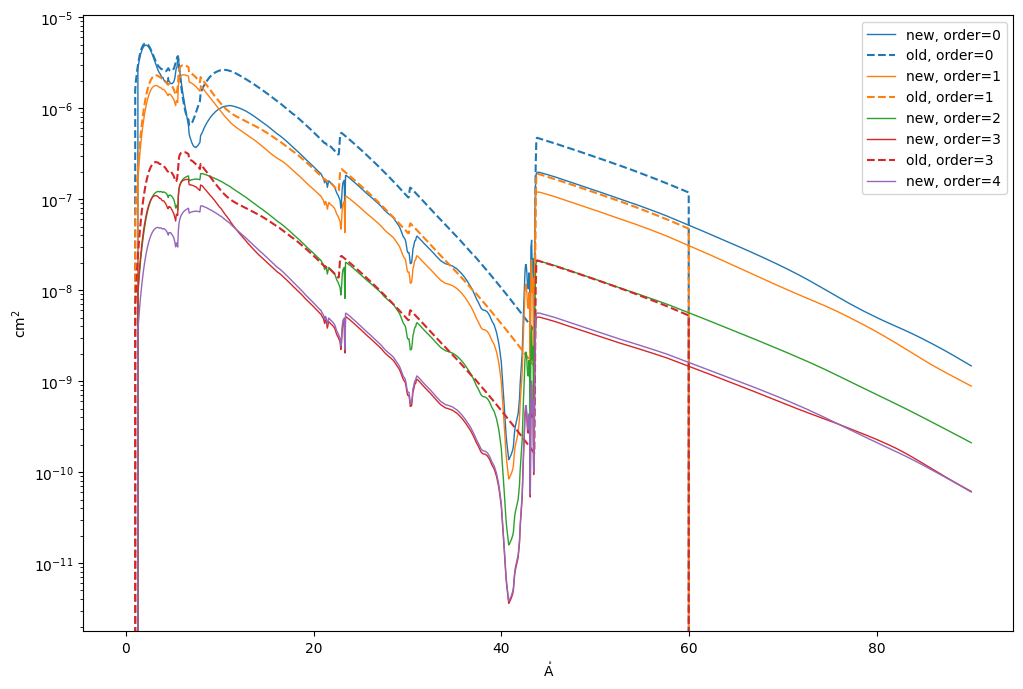

In [9]:
plt.figure(figsize=(12,8))
for i in np.arange(0,5):
    ch = SpectrogramChannel(i)
    with quantity_support():
        l, = plt.plot(ch.wavelength, ch.effective_area, label=f'new, order={ch.spectral_order}', lw=3 if i<0 else 1)
    if (i == 0 or i%2 != 0) and i<6:
        name = f"MOXSI_S{abs(i)}"
        genx_data = ch._read_genx_instrument_data(name)
        genx_wave = genx_data['wave']*u.angstrom
        genx_energy = const.h * const.c / genx_wave
        au_cr_layer = au_layer.transmissivity(ch._energy_no_inf) * cr_layer.transmissivity(ch._energy_no_inf)
        old_ge = ch._wavelength_interpolator(genx_wave, genx_data['grating']) * au_cr_layer
        old_ea = ch.geometrical_collecting_area * ch.filter_transmission * ch.detector_efficiency * old_ge
        with quantity_support():
            plt.plot(ch.wavelength, old_ea, label=f'old, order={ch.spectral_order}', color=l.get_color(), ls='--')
plt.legend()
plt.yscale('log')

(1e-06, 1)

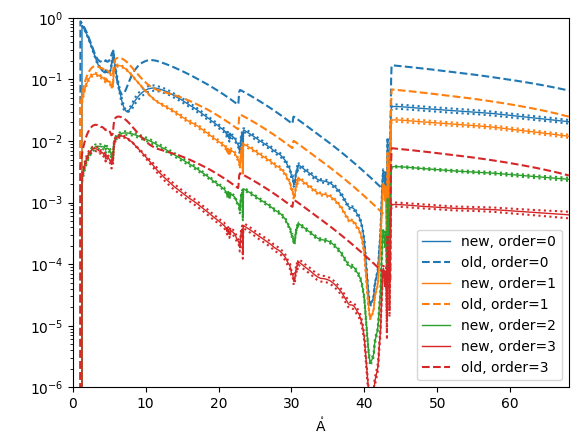

In [58]:
for i in np.arange(0,4):
    ch = SpectrogramChannel(i)
    tab4 = ch._read_grating_file(ch.grating_file, 3)
    tab6 = ch._read_grating_file(ch.grating_file, 4)
    with quantity_support():
        l, = plt.plot(ch.wavelength, ch.grating_efficiency, label=f'new, order={ch.spectral_order}', lw=3 if i<0 else 1)
        plt.plot(tab4['wavelength'], tab4[f'grating_efficiency_{i}'], color=l.get_color(), ls=':')
        plt.plot(tab6['wavelength'], tab6[f'grating_efficiency_{i}'], color=l.get_color(), ls=':')
    if i>=0 and i != 2:
        name = f"MOXSI_S{abs(i)}"
        genx_data = ch._read_genx_instrument_data(name)
        old_ge = ch._wavelength_interpolator(genx_data['wave']*u.angstrom, genx_data['grating'])
        with quantity_support():
            plt.plot(ch.wavelength, old_ge, label=f'old, order={ch.spectral_order}', color=l.get_color(), ls='--')
plt.legend()
plt.yscale('log')
plt.xlim(ch.wavelength[[0,-1]].to_value())
plt.ylim(1e-6,1)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


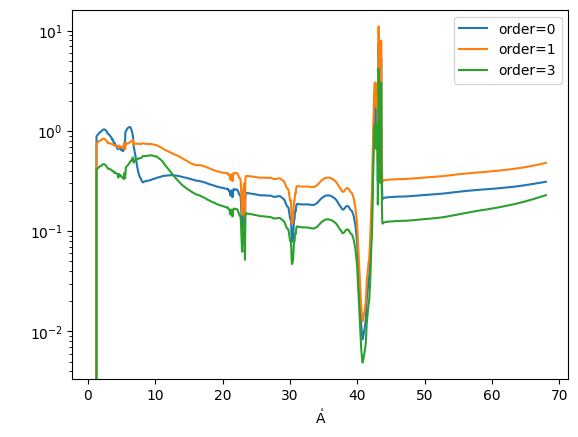

In [18]:
for i in np.arange(0,4):
    ch = SpectrogramChannel(i)
    if i>=0 and i != 2:
        name = f"MOXSI_S{abs(i)}"
        genx_data = ch._read_genx_instrument_data(name)
        old_ge = ch._wavelength_interpolator(genx_data['wave']*u.angstrom, genx_data['grating'])
        old_de = ch._wavelength_interpolator(genx_data['wave']*u.angstrom, genx_data['det'])
        old_ea = ch.geometrical_collecting_area * ch.filter_transmission * old_ge * old_de
        with quantity_support():
            plt.plot(ch.wavelength, ch.effective_area/old_ea, label=f'order={ch.spectral_order}')
plt.legend()
plt.yscale('log')

/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/ipykernel_45193/481627336.py:15: RuntimeWarning: invalid value encountered in divide
  plt.plot(ch1.wavelength, old_1_ge/old_3_ge, label='old 1 / old 3')


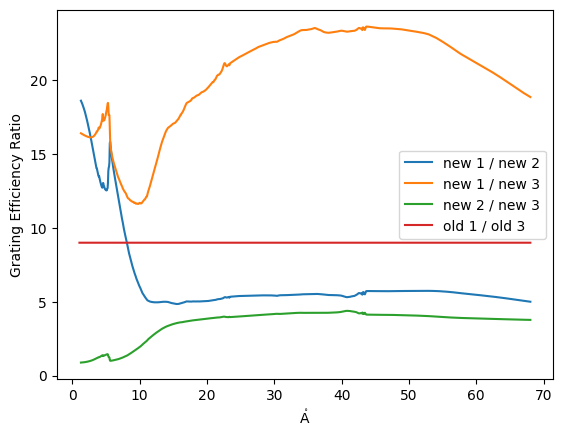

In [52]:
ch1 = SpectrogramChannel(1)
ch2 = SpectrogramChannel(2)
ch3 = SpectrogramChannel(3)
with quantity_support():
    plt.plot(ch1.wavelength, ch1.grating_efficiency/ch2.grating_efficiency, label='new 1 / new 2')
    plt.plot(ch3.wavelength, ch1.grating_efficiency/ch3.grating_efficiency, label='new 1 / new 3')
    plt.plot(ch3.wavelength, ch2.grating_efficiency/ch3.grating_efficiency, label='new 2 / new 3')
old_1 = ch1._read_genx_instrument_data('MOXSI_S1')
old_3 = ch1._read_genx_instrument_data('MOXSI_S3')
old_1_ge = ch1._wavelength_interpolator(old_1['wave']*u.angstrom, old_1['grating'])
#old_1_ea = ch1.geometrical_collecting_area * ch1.filter_transmission * old_1_ge * ch1.detector_efficiency
old_3_ge = ch1._wavelength_interpolator(old_3['wave']*u.angstrom, old_3['grating'])
#old_3_ea = ch1.geometrical_collecting_area * ch1.filter_transmission * old_3_ge * ch1.detector_efficiency
with quantity_support():
    plt.plot(ch1.wavelength, old_1_ge/old_3_ge, label='old 1 / old 3')
    #plt.plot(ch1.wavelength, old_1_ge/ch1.grating_efficiency, label='old 1 / new 1')
#plt.axhline(y=4, ls=':', color='k')
plt.ylabel('Grating Efficiency Ratio')
plt.legend()

(0.1, 20)

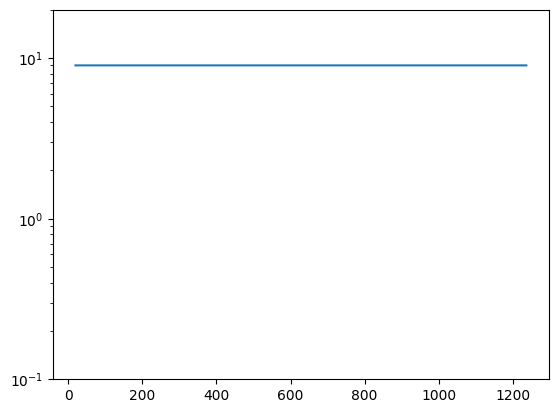

In [36]:
plt.plot(old_1_ea/old_3_ea)
plt.yscale('log')
plt.ylim(1e-1,20)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


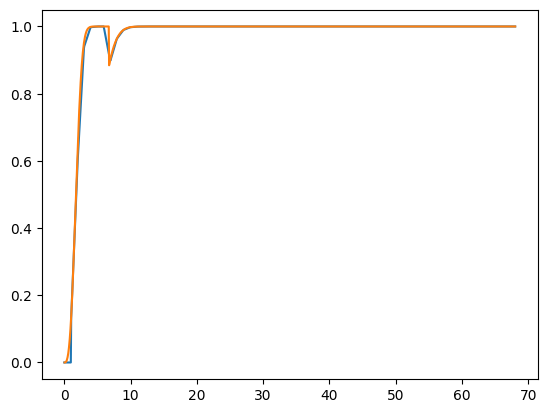

In [17]:
plt.plot(ch.wavelength, old_de)
plt.plot(ch.wavelength, ch.detector_efficiency)

In [21]:
ch = SpectrogramChannel(1)

In [14]:
tab = astropy.table.QTable.read(ch.grating_file, hdu=3)

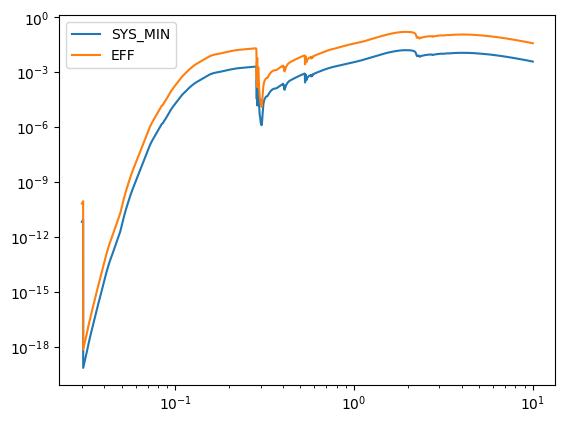

In [16]:
plt.plot(tab['ENERGY'], tab['SYS_MIN'].data[:, 12], label='SYS_MIN')
plt.plot(tab['ENERGY'], tab['EFF'].data[:, 12], label='EFF')
plt.xscale('log')
plt.yscale('log')
plt.legend()